In [1]:
%matplotlib inline
import re
from time import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from math import sqrt, log

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os; import json; import fileinput

fileinput.close() # sometimes fileinput is already active
def load_file(filename, max_lines = 150000):
    headers = None
    data = []
    for line in fileinput.input(filename):
        line = line.replace('\n', '')
        # Change separator between ""
        line = re.sub("\"[^\"]*\"", lambda x:x.group(0).replace(',',';'), line)
        line = line.split(',')
        if not headers:
            headers = line
            continue

        data.append(line)
        if len(data) > max_lines: break #and filename != 'test.csv': break
            
    fileinput.close()
    return headers, np.array(data)

h_train, df = load_file("train.csv", max_lines=1000000)
df_train = pd.DataFrame(df, columns=h_train)#.sample(300000)
h_train, df = load_file("test.csv", max_lines=1000000)
df_test = pd.DataFrame(df, columns=h_train)#.sample(300000)

df_train['Dates'] = df_train['Dates'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
#df_train['Resolution'] = df_train['Resolution'].apply(lambda x: x.replace('"', '').split('; '))
df_test['Dates'] = df_test['Dates'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
#df_test['Resolution'] = df_test['Resolution'].apply(lambda x: x.replace('"', '').split('; '))

df_train.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

total data:  877982
Index(['X', 'Y', 'day', 'summer', 'fall', 'winter', 'spring', 'X_-122.44',
       'Y_37.76', 'XY', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'year_2003', 'year_2004', 'year_2005', 'year_2006',
       'year_2007', 'year_2008', 'year_2009', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'DayOfWeek_Friday',
       'DayOfWeek_Monday', 'DayOfWeek_Saturday', 'DayOfWeek_Sunday',
       'DayOfWeek_Thursday', 'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday',
       'PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE',
       'PdDistrict_MISSION', 'PdDistrict_NORTHERN', 'PdDistrict_PARK',
       'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL',
       'PdDistrict_TENDERLOIN', 'IsInterection', 'Add_0', 'Add_1', 'Add_2',
       'Add_3', 'Add_4', 'Add_5', 'Add_6', 'Add_7', 'Add_8', 'Add_9'],
      dtype='object

,Address,X,Y,day,summer,fall,winter,spring,X_-122.44,Y_37.76,...,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,IsInterection
242848,100 Block of TURK ST,0.440905,0.667372,8,0,0,0,1,0.709623,0.772047,...,0,0,0,0,0,0,0,0,1,0
51045,100 Block of MONTICELLO ST,-1.899557,-2.070484,6,0,1,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,1,0,0
521546,2600 Block of 33RD AV,-2.677657,-1.189740,8,0,0,1,0,0.000000,0.000000,...,0,0,0,0,0,0,0,1,0,0


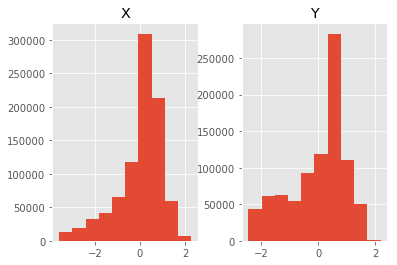

In [40]:
# Feature engineering
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler

def get_season(x):
    summer=0; fall=0; winter=0; spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

def prepare_df(df):
    df['month'] = df['Dates'].apply(lambda x: x.month)
    df['year'] = df['Dates'].apply(lambda x: x.year)
    # don't use .day because test/data set split is from every other 2 weeks of the whole data
    df['day'] = df['Dates'].apply(lambda x: x.day)
    df['X'] = pd.to_numeric(df['X'])
    df['Y'] = pd.to_numeric(df['Y'])
    
    # Season
    df["summer"], df["fall"], df["winter"], df["spring"] = zip(*df["month"].apply(get_season))
    
    """
    N = 10
    DIST = (df['X'].max() - df['X'].min()) / N #0.08 # gives best score
    for lmin in np.arange(df['X'].min(), df['X'].max(), DIST):
        lmax = min(lmin + DIST, df['X'].max())
        df['X_' + str(lmin)] = df['X'].apply(lambda x: (x-lmin)/(lmax-lmin) if lmin <= x <= lmax else 0)
        #df['X_' + str(lmin) + '_NOT'] = df['X'].apply(lambda x: 0 if lmin <= x <= lmax else 1)
    DIST = (df['Y'].max() - df['Y'].min()) / N
    for lmin in np.arange(df['Y'].min(), df['Y'].max(), DIST):
        lmax = min(lmin + DIST, df['Y'].max())
        df['Y_' + str(lmin)] = df['Y'].apply(lambda x: (x-lmin)/(lmax-lmin) if lmin <= x <= lmax else 0)
        #df['Y_' + str(lmin) + '_NOT'] = df['Y'].apply(lambda x: 0 if lmin <= x <= lmax else 1)
    """
    for lmin, lmax in [(-122.44, -122.40)]:
        df['X_' + str(lmin)] = df['X'].apply(lambda x: (x-lmin)/(lmax-lmin) if lmin <= x <= lmax else 0)
        #df['X_' + str(lmin) + '_NOT'] = df['X'].apply(lambda x: 0 if lmin <= x <= lmax else 1)
    for lmin, lmax in [(37.76, 37.79)]:
        df['Y_' + str(lmin)] = df['Y'].apply(lambda x: (x-lmin)/(lmax-lmin) if lmin <= x <= lmax else 0)
        #df['Y_' + str(lmin) + '_NOT'] = df['Y'].apply(lambda x: 0 if lmin <= x <= lmax else 1)
    df['XY'] = df['X'] * df['Y']

    # Encode
    df = pd.get_dummies(df, columns=['month', 'year', 'DayOfWeek', 'PdDistrict'])
    # 'Category' will be encoded later
    # This sets two categories as 1 when both are in the column
    #df = df.merge(df['Resolution'].str.join(sep=';').str.get_dummies(sep=';').add_prefix('Res_'), left_index=True, right_index=True)
    #df.drop(['Resolution'], axis=1, inplace=True)
    
    df["IsInterection"] = df["Address"].apply(lambda x: 1 if "/" in x else 0)

    # Memory optimization
    # Technical stuff, contributes nothing to analysis
    conv = df.select_dtypes(include=['int', 'float']).apply(pd.to_numeric,downcast='unsigned')
    df[conv.columns] = conv
    return df


df = prepare_df(df_train.copy(deep=True))
#del df_train # save memory
df_test_sub = prepare_df(df_test.copy(deep=True))
#del df_test # save memory

# Remove rows with wrong X/Y
df = df[df['X'] < -121.5]
df = df[df['Y'] < 60]
xy_scaler = StandardScaler()
xy_scaler.fit(df[["X","Y"]])
df[["X","Y"]] = xy_scaler.transform(df[["X","Y"]])
df_test_sub[["X","Y"]] = xy_scaler.transform(df_test_sub[["X","Y"]])

# Prepare for training
X = df.drop(['Dates', 'Resolution',
             # Text
             'Descript', 'Category', #'Address'
              ], axis=1)
#y = pd.get_dummies(df['Category'])
X_test_sub = df_test_sub.drop(['Dates', 'Id',
             # Text
             #'Address'
              ], axis=1)
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y = enc.fit_transform(df['Category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
print("total data: ", len(X))

# TODO do this and save the address names,
# so that the address columns in train and test are the same
def add_addresses(df):
    # Addresses with highest count, doesn't give a pattern -> probably no useful information
    add_most = list(df.groupby(['Address']).size().reset_index().sort_values([0])['Address'][-10:])
    for i, add in enumerate(add_most):
        df['Add_' + str(i)] = 0
        df[df['Address'] == add] = 1
    df.drop(['Address'], axis=1, inplace=True)
    return df

X_train = add_addresses(X_train)
X_test = add_addresses(X_test)

X = add_addresses(X)
X_test_sub = add_addresses(X_test_sub)

# From https://msdn.microsoft.com/en-us/library/azure/dn913056.aspx

"""
from copy import deepcopy
def add_logodds(df, logodds, logoddsPA):
    df["logoddsPA"] = df["Address"].apply(lambda x: logoddsPA[x])
    address_features = df["Address"].apply(lambda x: logodds[x])
    address_features.columns = ["logodds"+str(x) for x in range(len(address_features.columns))]
    df = df.join(address_features.ix[:,:])
    return df

# Trying around with the model
if True:
    addresses = sorted(X_train["Address"].unique())
    categories = sorted(X_train["Category"].unique())
    C_counts = df_train.groupby(["Category"]).size()
    A_C_counts = df_train.groupby(["Address","Category"]).size()
    A_counts = df_train.groupby(["Address"]).size()
    logodds = {}; logoddsPA = {}
    MIN_CAT_COUNTS = 2
    default_logodds = np.log(C_counts/len(X_train))-np.log(1.0-C_counts/float(len(X_train)))
    for addr in addresses:
        PA=A_counts[addr] / float(len(X_train))
        logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
        logodds[addr]=deepcopy(default_logodds)
        for cat in A_C_counts[addr].keys():
            if (A_C_counts[addr][cat]>MIN_CAT_COUNTS) and A_C_counts[addr][cat]<A_counts[addr]:
                PA=A_C_counts[addr][cat]/float(A_counts[addr])
                logodds[addr][categories.index(cat)]=np.log(PA)-np.log(1.0-PA)
        logodds[addr]=pd.Series(logodds[addr])
        logodds[addr].index=range(len(categories))

    X_train = add_logodds(X_train, logodds, logoddsPA)
    X_train.drop(['Address', 'Category'], inplace=True, axis=1)

    new_addresses=sorted(X_test["Address"].unique())
    new_A_counts=X_test.groupby("Address").size()
    only_new=set(new_addresses+addresses)-set(addresses)
    in_both=set(new_addresses).intersection(addresses)
    for addr in only_new:
        PA=new_A_counts[addr]/float(len(X_test)+len(X_train))
        logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
        logodds[addr]=deepcopy(default_logodds)
        logodds[addr].index=range(len(categories))
    for addr in in_both:
        PA=(A_counts[addr]+new_A_counts[addr])/float(len(X_test)+len(X_train))
        logoddsPA[addr]=np.log(PA)-np.log(1.-PA)

    X_test = add_logodds(X_test, logodds, logoddsPA)
    X_test.drop(['Address', 'Category'], inplace=True, axis=1)

# For submission
if False:
    addresses = sorted(X["Address"].unique())
    categories = sorted(X["Category"].unique())
    C_counts = X.groupby(["Category"]).size()
    A_C_counts = X.groupby(["Address","Category"]).size()
    A_counts = X.groupby(["Address"]).size()
    logodds = {}; logoddsPA = {}
    MIN_CAT_COUNTS = 2
    default_logodds = np.log(C_counts/len(X))-np.log(1.0-C_counts/float(len(X)))
    for addr in addresses:
        PA=A_counts[addr] / float(len(X))
        logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
        logodds[addr]=deepcopy(default_logodds)
        for cat in A_C_counts[addr].keys():
            if (A_C_counts[addr][cat]>MIN_CAT_COUNTS) and A_C_counts[addr][cat]<A_counts[addr]:
                PA=A_C_counts[addr][cat]/float(A_counts[addr])
                logodds[addr][categories.index(cat)]=np.log(PA)-np.log(1.0-PA)
        logodds[addr]=pd.Series(logodds[addr])
        logodds[addr].index=range(len(categories))

    X = add_logodds(X, logodds, logoddsPA)
    X.drop(['Address', 'Category'], inplace=True, axis=1)

    new_addresses=sorted(X_test_sub["Address"].unique())
    new_A_counts=X_test_sub.groupby("Address").size()
    only_new=set(new_addresses+addresses)-set(addresses)
    in_both=set(new_addresses).intersection(addresses)
    for addr in only_new:
        PA=new_A_counts[addr]/float(len(X_test_sub)+len(X))
        logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
        logodds[addr]=deepcopy(default_logodds)
        logodds[addr].index=range(len(categories))
    for addr in in_both:
        PA=(A_counts[addr]+new_A_counts[addr])/float(len(X_test_sub)+len(X))
        logoddsPA[addr]=np.log(PA)-np.log(1.-PA)

    X_test_sub = add_logodds(X_test_sub, logodds, logoddsPA)
    X_test_sub.drop(['Address'], inplace=True, axis=1)
"""

df.hist(['X', 'Y'])
print(X.columns)
print(X_test_sub.columns)
#del X_test_sub
#df.info()
#df.head(10)[['Address']]
X_train.head(3)

In [41]:
"""
from sklearn.decomposition import PCA
new_PCA=PCA(n_components=40)
new_PCA.fit(X_train)
plt.plot(new_PCA.explained_variance_ratio_)
plt.yscale('log')
plt.title("PCA explained ratio of features")
plt.show()
plt.plot(new_PCA.explained_variance_ratio_.cumsum())
plt.title("cumsum of PCA explained ratio")
"""
print()

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, log_loss
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

st = time()
pipe = Pipeline([
    ('scaler', StandardScaler()),
    #('pca', PCA(n_components=28)), # doesn't help
    # Score: 0.2341
    ('model', LogisticRegression(C=100, max_iter=10, warm_start=True, n_jobs=-1)),
    # Loss: 2.37
    #('model', RandomForestClassifier(n_estimators=20, max_depth=15, warm_start=True, n_jobs=-1))
])

if 0:
    pipe.fit(X_train, y_train)
    #y_pred = pipe.predict(X_test)
    y_pred_proba = pipe.predict_proba(X_test)
    #preds = np.zeros((len(X_test), len(y_pred_proba)))
    #for i_class in range(0, len(y_pred_proba)):
    #    for i_row in range(0, len(X_test)):
    #        if y_pred_proba[i_class][i_row, 0] < 1:
    #            preds[i_row][i_class] = y_pred_proba[i_class][i_row, 1]
    #        else:
    #            preds[i_row][i_class] = 0
    y_pred = y_pred_proba # preds
    print("Score:", pipe.score(X_test, y_test))
    #print("Log loss:", log_loss(pd.get_dummies(y_test), y_pred))

if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {
        'model__max_iter': [10, 50, 100],
        #'model__warm_start': [True, False]
        #'model__C': [1e2, 1e1, 1e0]
                 }
    grid = GridSearchCV(pipe, param_grid, cv=2, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    
print('Done in {:.2f} min.'.format((time() - st)/60))

Done in 0.00 min.


In [43]:
# Don't use this for data analysis! It's a tool for model analysis only
# Is wrong when using PCA
#print((y_pred_proba[0]))
#print((np.array(pd.get_dummies(y_test))[0]))

features = {}
try:
    #scores = pipe.named_steps['model'].feature_importances_
    scores = np.absolute(pipe.named_steps['model'].coef_).sum(axis=0)
    i=0
    for col in X.columns:
        features[col] = scores[i]
        i+=1     
except Exception as e:
    print(e)
    pass

# Print the best ones
import operator
features_sorted = sorted(features.items(), key=operator.itemgetter(1), reverse=True)
for f, v in features_sorted: #[:50]:
    print("{}: {:.5f}".format(f, v))
#features_sorted

'LogisticRegression' object has no attribute 'coef_'


In [44]:
# For submission
st = time()
pipe.fit(X, y)
print('{:.2f} min. trained'.format((time() - st)/60))
#y_pred_sub = pipe.predict(X_test_sub)
y_pred_proba = pipe.predict_proba(X_test_sub)
#preds = np.zeros((len(X_test_sub), len(y_pred_proba)))
#for i_class in range(0, len(y_pred_proba)):
#    for i_row in range(0, len(X_test)):
#        if y_pred_proba[i_class][i_row, 0] < 1:
#            preds[i_row][i_class] = y_pred_proba[i_class][i_row, 1]
#        else:
#            preds[i_row][i_class] = 0
y_pred_sub = y_pred_proba # preds
print('{:.2f} min. done.'.format((time() - st)/60))

19.36 min. trained
19.39 min. done.


In [45]:
columns = 'Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS'.split(',')
#print(len(columns))
#print(len(y_pred_sub[0]))
ids = list(range(0, len(df_test_sub)))

import csv
csvfile = open('submission.csv', 'w')
writer = csv.writer(csvfile)
writer.writerow(columns)
for i in range(0, len(df_test_sub)):
    if i%300000==0: print("{:.0f}%".format(i / len(df_test_sub) * 100))
    row = y_pred_sub[i].round(decimals=6) # round to reduce size of submission.csv
    writer.writerow([i] + list(row))

csvfile.close()
print("Finished.")

40
39
0%
34%
68%
Finished.


In [ ]:
#X_test = add_addresses(X_test)
#pipe.score(X_test, y_test)